In [39]:
#import some libraries 
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [29]:
#constants

IMAGE_SIZE = 256
BATCH_SIZE = 32 
CHANNELS = 3
EPOCHS = 20

In [3]:
#import our dataset from directory
    #shuffle randomly shuffle the images
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Papa___Tizon_tardio', 'Papa___Tizon_temprano', 'Papa___saludable']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 2 2]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


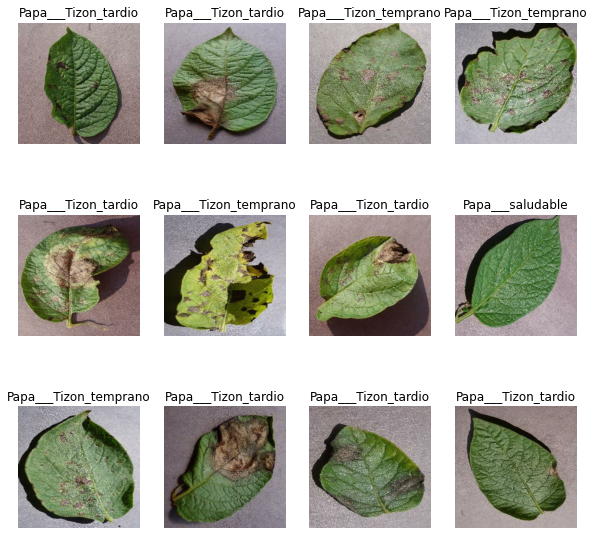

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    #getting sizes
    ds_size = len(ds)
    #shuffle dataset
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    #getting partitions of dataset
    #Training dataset
    train_ds =ds.take(train_size) #array[:train_size]
    #Validation dataset
    val_ds = ds.skip(train_size).take(val_size)
    #Test dataset
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
#improving performance with caching and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
#Preprocessing image : Resize, Scale
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
#Applying Data Augmentation to make a robust model
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
#input shape
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
#creating the model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [16]:
 model.compile(
     optimizer = "adam",
     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
     metrics =['accuracy']
 )

In [30]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
54/54 [==============================] - 119s 2s/step - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.0506 - val_accuracy: 0.9844
Epoch 2/20
54/54 [==============================] - 117s 2s/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 3/20
54/54 [==============================] - 121s 2s/step - loss: 0.0142 - accuracy: 0.9931 - val_loss: 0.0467 - val_accuracy: 0.9896
Epoch 4/20
54/54 [==============================] - 122s 2s/step - loss: 0.0325 - accuracy: 0.9884 - val_loss: 0.0532 - val_accuracy: 0.9844
Epoch 5/20
54/54 [==============================] - 122s 2s/step - loss: 0.0181 - accuracy: 0.9959 - val_loss: 0.0702 - val_accuracy: 0.9792
Epoch 6/20
54/54 [==============================] - 124s 2s/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.1282 - val_accuracy: 0.9323
Epoch 7/20
54/54 [==============================] - 139s 3s/step - loss: 0.0314 - accuracy: 0.9873 - val_loss: 0.0299 - val_accuracy: 0.9896
Epoch 8/20
54

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 474ms/step - loss: 0.0261 - accuracy: 0.9844


In [32]:
#variables to plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

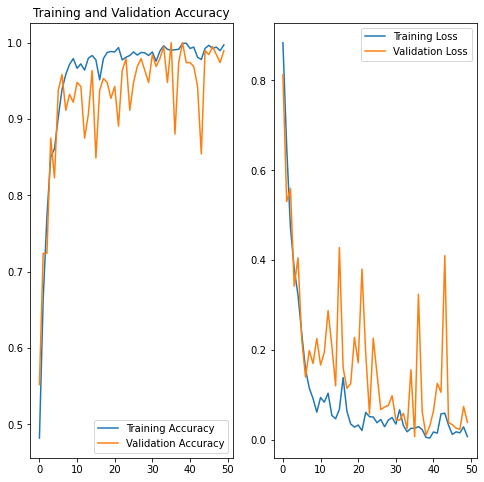

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

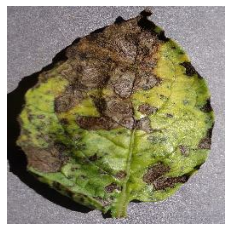

In [34]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')

first image to predict
Etiqueta Actual : Papa___Tizon_temprano
Etiqueta de la Predicción:  Papa___Tizon_temprano


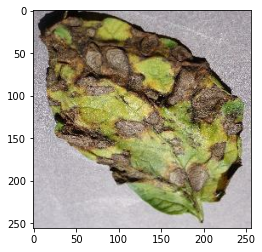

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("Etiqueta Actual :",class_names [first_label])
    batch_prediction = model.predict(images_batch)
    print("Etiqueta de la Predicción: ",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

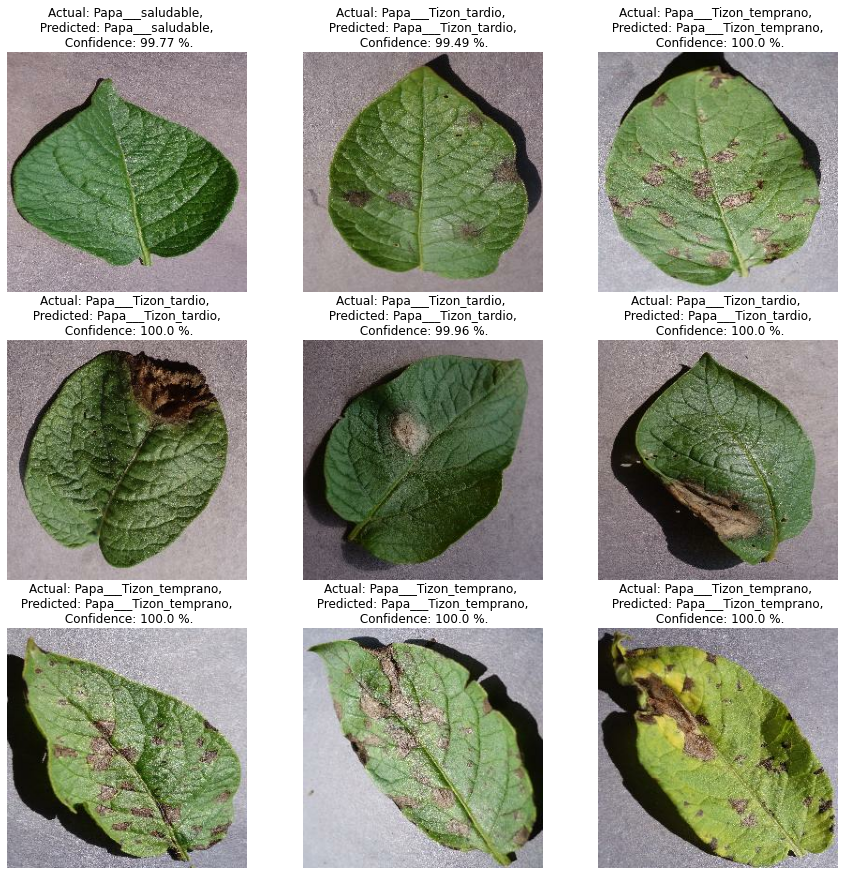

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence} %.')
        plt.axis('off')

In [38]:
model_version = 2
model.save(f'../Models/{model_version}')

INFO:tensorflow:Assets written to: ../Models/2\assets
